1. Try to collect typical blob with different initial weight, see how does the final optimized weight for each strucutre change. 
2. Change the initial weight of area and eccentricity, see how does the final optimzied weight change. 
3. Crop a small window and sweep the window across the whole image, compute the score for it. Define region similarity by patch-to-patch blob-to-blob matching and count the total similarity. 

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

from xj_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def fun_similar_ratio(data, threshold_simu):
    return np.float(np.count_nonzero(data>threshold_simu))/len(data)
def fun_max_similarity_with_plot(positive_data, negative_data, plotFig=False):
    tempPosCum = []
    tempNegCum = []
    tempRanges = np.arange(0,1.05,0.05)
    for threshold_simu in tempRanges:
        tempPosCum.append(fun_similar_ratio(positive_data, threshold_simu=threshold_simu))
        tempNegCum.append(fun_similar_ratio(negative_data, threshold_simu=threshold_simu))

    tempDifference = np.array(tempPosCum) - np.array(tempNegCum)
    tempMax = np.max(tempDifference)
    tempPos = tempRanges[tempDifference==tempMax]
    if plotFig:
        plt.figure()
        plt.plot(tempRanges, tempPosCum, label='Positive')
        plt.plot(tempRanges, tempNegCum, label='Negative')
        plt.plot(tempRanges, tempDifference, label='Difference')
        plt.xlabel('Threshold Similarity')
        plt.title('Max difference = %f @ s=%f'%(tempMax,tempPos))
        plt.grid()
        plt.legend()
    return tempPos, tempMax

def fun_ROC(positive_data, negative_data):
    """ Input: positive_data, negative_data are 1D numpy.array
    Output: simMax, maxDiff, ranges, posCum, negCum"""
    tempPosCum = []
    tempNegCum = []
    tempRanges = np.arange(0,1.05,0.05)
    for threshold_simu in tempRanges:
        tempPosCum.append(fun_similar_ratio(positive_data, threshold_simu=threshold_simu))
        tempNegCum.append(fun_similar_ratio(negative_data, threshold_simu=threshold_simu))
    return tempRanges, tempPosCum, tempNegCum

def fun_find_max(x,y, mode='returnAll'):
    x = np.array(x)
    y = np.array(y)
    maxY = np.max(y)
    maxX = x[y == maxY]
    if mode == 'returnAll':
        return maxX, maxY
    elif mode == 'returnFirst':
        if type(maxX) == np.ndarray:
            return maxX[0], maxY

def fun_find_max_similarity_difference(data_range, posCum, negCum):
    difference = np.array(posCum) - np.array(negCum)
    threshold_sim, maxSimDiff = fun_find_max(data_range, difference)
    return threshold_sim, maxSimDiff
    


def fun_max_similarity_v2(positive_data, negative_data, plotFig=False):
    numBins = 20;
    posCum_count = scipy.stats.cumfreq(positive_data, numbins=numBins,defaultreallimits=(0,1))
    posCum = posCum_count.cumcount / posCum_count.cumcount[-1]
    negCum_count = scipy.stats.cumfreq(negative_data, numbins=numBins,defaultreallimits=(0,1))
    negCum = negCum_count.cumcount / negCum_count.cumcount[-1]
    scan_range = np.arange(0,1, 1.0/numBins)
    difference = posCum - negCum
    maxSimDiff = np.max(difference)
    pos = scan_range[difference==maxSimDiff]
 
    if plotFig:
        plt.figure()
        plt.plot(scan_range, posCum, label='Positive')
        plt.plot(scan_range, negCum, label='Negative')
        plt.plot(scan_range, difference, label='Difference')
        plt.xlabel('Threshold Similarity')
        plt.title('Max difference = %f @ s=%f'%(maxSimDiff,pos))
        plt.grid()
        plt.legend()
    return pos, maxSimDiff

# Load data

In [19]:
stack = 'MD589'
dataFolderName = 'NoCoors_RandomFalseMatched'
scan_parameters = load_typical_cell_data(what='scan_parameters', stack=stack, sec=200, dataFolderName=dataFolderName, dataType='typical')

In [20]:
section_valid_list = fun_get_valid_section_list(stack)
section_load_list = list(section_valid_list)

# Load saved blob features of {typical_blob, matched_pair, false_typical, false_matched_pairs}
typical_blob_props = collections.defaultdict(dict)
matched_blob_props = collections.defaultdict(dict)
false_typical_blob_props = collections.defaultdict(dict)
false_matched_blob_props = collections.defaultdict(dict)
for tempProp in scan_parameters['prop_to_save']:
    for tempSec in section_valid_list:
        try:
            typical_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='typical')
            matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='matched')
            false_typical_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_typical')
            false_matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_matched')
        except:
            section_load_list.remove(tempSec)
            print('Cannot load the data of section %d'%tempSec)
            
for tempSec in section_valid_list:
    typical_blob_props[tempSec]['numBlobs'] = len(typical_blob_props[tempSec]['area'])
    false_typical_blob_props[tempSec]['numBlobs'] = len(false_typical_blob_props[tempSec]['area'])
# Load matching infomation b           
for tempProp in ['section', 'TBID']:
    for tempSec in section_valid_list:
        try:
            matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='matched')
            false_matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_matched')
        except:
            section_load_list.remove(tempSec)
            print('Cannot load the data of section %d'%tempSec)
# Get relation between TBID and matched blob idx
TBID_to_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(typical_blob_props[tempSec]['numBlobs']):
        TBID_to_matched_blob[tempSec][tempBID] = np.where(matched_blob_props[tempSec]['TBID']==tempBID)[0]

# Get map between False typical blob ID and false_matched blobs idx
FTBID_to_false_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(false_typical_blob_props[tempSec]['numBlobs']):
        FTBID_to_false_matched_blob[tempSec][tempBID] = np.where(false_matched_blob_props[tempSec]['TBID']==tempBID)[0]

In [21]:
# Annotation data:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
vertice_dic = collections.defaultdict(dict)
structure_section_list = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    vertice_dic[structure_name] = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()} 
    structure_section_list[structure_name] = np.sort(vertice_dic[structure_name].keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807


## Pre processing

In [22]:
learning_parameters = {}
learning_parameters['training_props'] = ['area', 'eccentricity','orientation', 'compactness','moments_hu']

In [23]:
TBID_in_structure = collections.defaultdict(dict)
FTBID_in_structure = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
        TBID_in_structure[tempSec][structure_name] =  np.where(fun_blobs_in_polygen(typical_blob_props[tempSec]['centroid'], vertice_dic[structure_name][tempSec]))[0]
        FTBID_in_structure[tempSec][structure_name] = np.where(fun_blobs_in_polygen(false_typical_blob_props[tempSec]['centroid'], vertice_dic[structure_name][tempSec]))[0]

In [24]:
# Positive
nested_dict = lambda: defaultdict(nested_dict)
positive_similarity_sec_prop = collections.defaultdict(nested_dict)

for structure_name in set(contour_df['name']):
    for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
        for tempProp in learning_parameters['training_props']:
            temp_sec_prop_similarity = []
            for tempBID in TBID_in_structure[tempSec][structure_name]:
                temp = fun_similarity(typical_blob_props[tempSec][tempProp][tempBID], 
                                                      matched_blob_props[tempSec][tempProp][TBID_to_matched_blob[tempSec][tempBID]],distance_type=tempProp)
                temp_sec_prop_similarity += temp
            positive_similarity_sec_prop[structure_name][tempSec][tempProp] = temp_sec_prop_similarity
        
positive_similarity_prop = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    for tempProp in learning_parameters['training_props']:
        positive_similarity_prop[structure_name][tempProp] = np.concatenate(tuple([np.array(record[tempProp]) for record in positive_similarity_sec_prop[structure_name].itervalues() if len(record[tempProp]) is not 0]))
positive_training_data = {}
for structure_name in set(contour_df['name']):
    temp_training_data = []
    for tempProp in learning_parameters['training_props']:
        temp_training_data.append(positive_similarity_prop[structure_name][tempProp])
    positive_training_data[structure_name] = np.column_stack(tuple(temp_training_data))
    


In [25]:
negative_similarity_sec_prop = collections.defaultdict(nested_dict)
for structure_name in set(contour_df['name']):
    for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
        for tempProp in learning_parameters['training_props']:
            temp_sec_prop_similarity = []
            for tempBID in FTBID_in_structure[tempSec][structure_name]:
                temp = fun_similarity(false_typical_blob_props[tempSec][tempProp][tempBID], 
                                                      false_matched_blob_props[tempSec][tempProp][FTBID_to_false_matched_blob[tempSec][tempBID]],distance_type=tempProp)
                temp_sec_prop_similarity += temp
            negative_similarity_sec_prop[structure_name][tempSec][tempProp] = temp_sec_prop_similarity

negative_similarity_prop = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    for tempProp in learning_parameters['training_props']:
        negative_similarity_prop[structure_name][tempProp] = np.concatenate(tuple([np.array(record[tempProp]) for record in negative_similarity_sec_prop[structure_name].itervalues() if len(record[tempProp]) is not 0]))
negative_training_data = {}
for structure_name in set(contour_df['name']):
    temp_training_data = []
    for tempProp in learning_parameters['training_props']:
        temp_training_data.append(negative_similarity_prop[structure_name][tempProp])
    negative_training_data[structure_name] = np.column_stack(tuple(temp_training_data))


In [26]:
structure_name_list = np.array(positive_training_data.keys())
training_sample_num_pos = np.array([np.shape(positive_training_data[tmp])[0] for tmp in structure_name_list])
tmp_order = np.argsort(training_sample_num_pos)[::-1]
structure_name_list = structure_name_list[tmp_order]
training_sample_num_pos = training_sample_num_pos[tmp_order]

In [40]:
structure_name_list

array(['SC', 'IC', 'Sp5C', 'Pn', 'VCA', 'SNR', 'DC', 'IO', 'Sp5I', 'VLL',
       'Cb', 'LPB', 'SNC', 'Sp5O', 'LRt', 'Pr5VL', 'Tz', 'LC', 'VCP',
       'MVe', '10N', '7N', 'APT', '12N', 'SuVe', 'Pr5DM', 'PBG', 'RtTg',
       'VTA', 'RMC', 'Dk', 'Sol', '5N', 'PF', 'X', 'AP', 'Gr', '3N', 'MPB',
       'MnR', 'IPR', 'LSO', 'RR', 'IPC', 'VTg', 'EW', 'Pr5', 'MiTg',
       'DTgP', 'Amb', 'IPA', 'RPF', 'DRD', 'LVe', 'R', 'ECu', 'IF', 'RPC',
       '7n', '6N', '4N', '5TT', 'Li', 'IPL', '8n'],
      dtype='|S5')

# Optimization

In [11]:
def fun_ROC(positive_data, negative_data, scaning_step=0.025):
    """ Input: positive_data, negative_data are 1D numpy.array
    Output: ranges, posCum, negCum"""
    tempPosCum = []
    tempNegCum = []
    tempRanges = np.arange(0,1+scaning_step,scaning_step)
    for threshold_simu in tempRanges:
        tempPosCum.append(fun_similar_ratio(positive_data, threshold_simu=threshold_simu))
        tempNegCum.append(fun_similar_ratio(negative_data, threshold_simu=threshold_simu))
    return tempRanges, tempPosCum, tempNegCum

def fun_find_max(x,y, mode='returnAll'):
    x = np.array(x)
    y = np.array(y)
    maxY = np.max(y)
    maxX = x[y == maxY]
    if mode == 'returnAll':
        return maxX, maxY
    elif mode == 'returnFirst':
        if type(maxX) == np.ndarray:
            return maxX[0], maxY

def fun_find_max_similarity_difference(data_range, posCum, negCum):
    difference = np.array(posCum) - np.array(negCum)
    threshold_sim, maxSimDiff = fun_find_max(data_range, difference)
    return threshold_sim, maxSimDiff

def fun_SGD_score(weight, positive_training_data, negative_training_data):
    scan_range, posCum, negCum = fun_ROC(np.dot(positive_training_data, weight), np.dot(negative_training_data, weight) )
    _, maxSimDiff = fun_find_max_similarity_difference(scan_range, posCum, negCum)
    return maxSimDiff

def fun_SGD_score_v2(weight, positive_training_data, negative_training_data):
    scan_range, posCum, negCum = fun_ROC(np.dot(positive_training_data, weight), np.dot(negative_training_data, weight) )
    threshold, maxSimDiff = fun_find_max_similarity_difference(scan_range, posCum, negCum)
    return threshold, maxSimDiff
# Gradient descent: compute gradient
# def fun_gradient_descent(learning_vectors, initial_score, initial_weight,positive_data, negative_data):
#     tempMaxSimDiff = -1
# #     numStep = 0
#     while True:
#         tempMaxSimDiffList = []
#         tempWeightList = []
#         for learning_vector in learning_vectors:
#             # Update weight, with nonegative normalized constrains
#             tempWeight = initial_weight.copy() + learning_vector
#             tempWeight[tempWeight<0] = 0
#             tempWeight = tempWeight/np.sum(tempWeight)
#             tempWeightList.append(tempWeight)
#             tempMaxSimDiffList.append(fun_SGD_score(tempWeight, positive_data, negative_data))
#         tempWeight, tempMaxSimDiff = fun_find_max(x=tempWeightList, y=tempMaxSimDiffList,mode='returnFirst')
#         if tempMaxSimDiff > initial_score:
# #             numStep +=1
#             initial_score = tempMaxSimDiff
#             initial_weight = tempWeight
#         else:
# #             print('Reach Local maximum. Break.')
#             break
#     return initial_score, initial_weight
    
    
def fun_gradient_descent(learning_vectors, initial_score, initial_weight,positive_data, negative_data, random_sample_num=None):
    tempMaxSimDiff = -1
    if random_sample_num is not None:
        num_positive_data = np.shape(positive_data)[0]
        num_negative_data = np.shape(negative_data)[0]
        positive_data_idx = np.arange(0, num_positive_data, dtype=np.int32)
        negative_data_idx = np.arange(0, num_negative_data, dtype=np.int32)
#     numStep = 0
    while True:
        if (random_sample_num is not None) and (num_positive_data > random_sample_num):
            selected_positive_idx = np.random.choice(positive_data_idx, size=random_sample_num, replace=False)
            positive_training_data = positive_data[selected_positive_idx]
        else:
            positive_training_data = positive_data
        if (random_sample_num is not None) and (num_negative_data > random_sample_num):
            selected_negative_idx = np.random.choice(negative_data_idx, size=random_sample_num, replace=False)
            negative_training_data = negative_data[selected_negative_idx]
        else:
            negative_training_data = negative_data
            
        tempMaxSimDiffList = []
        tempWeightList = []
        for learning_vector in learning_vectors:
            # Update weight, with nonegative normalized constrains
            tempWeight = initial_weight.copy() + learning_vector
            tempWeight[tempWeight<0] = 0
            tempWeight = tempWeight/np.sum(tempWeight)
            tempWeightList.append(tempWeight)
            tempMaxSimDiffList.append(fun_SGD_score(tempWeight, positive_training_data, negative_training_data))
        tempWeight, tempMaxSimDiff = fun_find_max(x=tempWeightList, y=tempMaxSimDiffList,mode='returnFirst')
        if tempMaxSimDiff > initial_score:
#             numStep +=1
            initial_score = tempMaxSimDiff
            initial_weight = tempWeight
        else:
#             print('Reach Local maximum. Break.')
            break
    return initial_score, initial_weight
    
    
    
def fun_get_weight_vec_length(training_props):
    prop_length = {}
    prop_length['area'] = 1
    prop_length['orientation'] = 1
    prop_length['eccentricity'] = 1
    prop_length['moments_hu'] = 7
    prop_length['equivalent_diameter'] = 1
    prop_length['major_axis_length'] = 1
    prop_length['solidity'] = 1
    prop_length['minor_axis_length'] = 1
    prop_length['perimeter'] = 1
    prop_length['compactness'] = 1
    weight_vec_length = 0
    for prop in training_props:
        weight_vec_length += prop_length[prop]
        
    return weight_vec_length


In [19]:
def fun_optimize_weights_with_SGD(positive_training_data, negative_training_data, learning_parameters, structure_name=None):
    training_props = learning_parameters['training_props']
    sim_vector_length = learning_parameters['weight_length']
    if structure_name==None:
        structure_name = learning_parameters['structure_name']
        positive_data = positive_training_data[structure_name]
        negative_data = negative_training_data[structure_name]
    elif structure_name=='All':
        
        positive_data = np.vstack(tuple(positive_training_data.values()))
        negative_data = np.vstack(tuple(negative_training_data.values()))
    else:
        positive_data = positive_training_data[structure_name]
        negative_data = negative_training_data[structure_name]
    
    stack = learning_parameters['stack']    
    
    save_root_folder = learning_parameters['save_root_folder']
    save_info_method = learning_parameters['method'] 
    save_data_set = learning_parameters['data_set']
    
    training_props = learning_parameters['training_props']
    numTrial = learning_parameters['numTrial']
    learning_rate = learning_parameters['learning_rate']
    max_sample_num = learning_parameters['max_sample_num']





    temp_matrix = np.eye(sim_vector_length, dtype=np.float)
    learning_vectors = np.hstack(tuple([temp_matrix * learning_rate, temp_matrix * -learning_rate]))
    learning_vectors = np.split(learning_vectors,sim_vector_length*2, axis=1)

    report_times = numTrial/20
    data_maxSimDiff = []
    data_weight = []
    for idx in range(numTrial):
        if idx % report_times == 0:
            print('Structure %s %f finished.'%(structure_name, float(idx)/numTrial))
        weight = np.random.random(size=[sim_vector_length, 1])
        weight = weight/np.sum(weight)
        scan_range, posCum, negCum = fun_ROC(np.dot(positive_data, weight), np.dot(negative_data, weight) )
        threshold_sim, maxSimDiff = fun_find_max_similarity_difference(scan_range, posCum, negCum)
        optimized_maxSimDiff, optimized_weight = fun_gradient_descent(learning_vectors=learning_vectors,
                                                                      initial_score=maxSimDiff, 
                                                                      initial_weight=weight , 
                                                                      positive_data=positive_data, 
                                                                      negative_data=negative_data,random_sample_num=max_sample_num)
        data_maxSimDiff.append(optimized_maxSimDiff)
        data_weight.append(optimized_weight)

    # Save data    
    fp = os.path.join(save_root_folder, stack, save_data_set , structure_name, save_info_method)
    fun_create_folder(fp)
    bp.pack_ndarray_file(np.array(data_weight), filename= os.path.join(fp, 'weight.bp'))
    bp.pack_ndarray_file(np.array(data_maxSimDiff), filename=os.path.join(fp, 'maxSimDiff.bp'))
    save_pickle(learning_parameters, fp=os.path.join(fp, 'learning_parameters.pkl'))


In [43]:
learning_parameters = {}
learning_parameters['learning_rate'] = 0.05
learning_parameters['save_root_folder'] = '/shared/blob_matching_atlas/training_weight'
learning_parameters['method'] = 'SGD_10_11'
learning_parameters['data_set'] = dataFolderName
# learning_parameters['structure_name'] = '7N'
learning_parameters['training_props'] = ['area', 'eccentricity', 'compactness','orientation','moments_hu']
learning_parameters['numTrial'] = 10000
learning_parameters['stack'] = scan_parameters['stack']
learning_parameters['weight_length'] = fun_get_weight_vec_length(learning_parameters['training_props'])
learning_parameters['max_sample_num'] = 10000
learning_parameters['roc_scaning_step'] = 0.05

In [ ]:
fun_optimize_weights_with_SGD(positive_training_data, negative_training_data, learning_parameters, structure_name='All')

Structure All 0.000000 finished.
Structure All 0.050000 finished.
Structure All 0.100000 finished.
Structure All 0.150000 finished.
Structure All 0.200000 finished.
Structure All 0.250000 finished.
Structure All 0.300000 finished.
Structure All 0.350000 finished.
Structure All 0.400000 finished.
Structure All 0.450000 finished.
Structure All 0.500000 finished.
Structure All 0.550000 finished.
Structure All 0.600000 finished.
Structure All 0.650000 finished.
Structure All 0.700000 finished.


In [ ]:
for structure_name in structure_section_list.keys():
    fun_optimize_weights_with_SGD(positive_training_data, negative_training_data, learning_parameters, structure_name=structure_name)

Structure Tz 0.000000 finished.
Structure Tz 0.050000 finished.
Structure Tz 0.100000 finished.
Structure Tz 0.150000 finished.
Structure Tz 0.200000 finished.
Structure Tz 0.250000 finished.
Structure Tz 0.300000 finished.
Structure Tz 0.350000 finished.
Structure Tz 0.400000 finished.
Structure Tz 0.450000 finished.
Structure Tz 0.500000 finished.


In [18]:
# Function test
%prun fun_optimize_weights_with_SGD(positive_training_data, negative_training_data, learning_parameters, structure_name='7N')

Structure 7N 0.000000 finished.
Structure 7N 0.050000 finished.
Structure 7N 0.100000 finished.
Structure 7N 0.150000 finished.
Structure 7N 0.200000 finished.
Structure 7N 0.250000 finished.
Structure 7N 0.300000 finished.
Structure 7N 0.350000 finished.
Structure 7N 0.400000 finished.
Structure 7N 0.450000 finished.
Structure 7N 0.500000 finished.
Structure 7N 0.550000 finished.
Structure 7N 0.600000 finished.
Structure 7N 0.650000 finished.
Structure 7N 0.700000 finished.
Structure 7N 0.750000 finished.
Structure 7N 0.800000 finished.
Structure 7N 0.850000 finished.
Structure 7N 0.900000 finished.
Structure 7N 0.950000 finished.


Folder created: /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/7N/SGD_10_02

In [ ]:
from multiprocess import Pool 
task_pool = Pool(6)
task_pool.map(lambda structure_name: fun_optimize_weights_with_SGD(positive_training_data, negative_training_data, learning_parameters, structure_name=structure_name), structure_section_list.keys() )

Structure Tz 0.000000 finished.
Structure ECu 0.000000 finished.
Structure SNC 0.000000 finished.
Structure Pn 0.000000 finished.
Structure 10N 0.000000 finished.
Structure IPL 0.000000 finished.
Structure IPL 0.050000 finished.
Structure IPL 0.100000 finished.
Structure ECu 0.050000 finished.
Structure IPL 0.150000 finished.
Structure 10N 0.050000 finished.
Structure IPL 0.200000 finished.
Structure ECu 0.100000 finished.
Structure SNC 0.050000 finished.
Structure Tz 0.050000 finished.
Structure IPL 0.250000 finished.
Structure IPL 0.300000 finished.
Structure ECu 0.150000 finished.
Structure IPL 0.350000 finished.
Structure 10N 0.100000 finished.
Structure IPL 0.400000 finished.
Structure Pn 0.050000 finished.
Structure ECu 0.200000 finished.
Structure IPL 0.450000 finished.
Structure SNC 0.100000 finished.
Structure Tz 0.100000 finished.
Structure IPL 0.500000 finished.
Structure ECu 0.250000 finished.
Structure IPL 0.550000 finished.
Structure 10N 0.150000 finished.
Structure IPL 0

Process PoolWorker-6:
Process PoolWorker-1:
Process PoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 258, in _bootstrap
Process PoolWorker-5:
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 258, in _bootstrap
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 258, in _bootstrap
Traceback (most recent call last):
    self.run()
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 114, in run
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 114, in run
    self.run()
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 258, in _bootstrap
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/multiprocess/process.py", line 114, in run
    self._target(*self.

Structure EW 0.000000 finished.
Structure 12N 0.000000 finished.
Structure RPC 0.000000 finished.
Structure RPF 0.000000 finished.


In [ ]:
for tempStructure_name in structure_section_list.keys():
    learning_parameters['structure_name'] = tempStructure_name
    fun_optimize_weights_with_SGD(positive_training_data, negative_training_data, learning_parameters)

# Result analysis

In [45]:
def fun_get_learning_data_path(what, stack, data_set, structure_name, method, ext=None):
    LERANING_ROOT_PATH = '/shared/blob_matching_atlas/training_weight'
    if what=='weight':
        fn = 'weight.bp'
    elif what=='learning_parameters':
        fn = 'learning_parameters.pkl'
    elif what=='maxSimDiff':
        fn = 'maxSimDiff.bp'
    else:
        assert ext is not None, 'Please specify extension'
        fn = what + ext
    
    fp = os.path.join(LERANING_ROOT_PATH, stack, data_set, structure_name, method, fn)
    return fp
         
        

In [ ]:
stack = 'MD589'
dataFolderName = 'NoCoors_RandomFalseMatched'
scan_parameters = load_typical_cell_data(what='scan_parameters', stack=stack, sec=200, dataFolderName=dataFolderName, dataType='typical')

In [8]:
load_structure = 'All'
data_tag = 'SGD_10_11'
data_weight = {}
data_maxSimDiff = {}

data_weight[load_structure] = load_data(fun_get_learning_data_path(what='weight', stack=stack, data_set=dataFolderName, structure_name=load_structure, method=data_tag))
data_maxSimDiff[load_structure] = load_data(fun_get_learning_data_path(what='maxSimDiff', stack=stack, data_set=dataFolderName, structure_name=load_structure, method=data_tag))

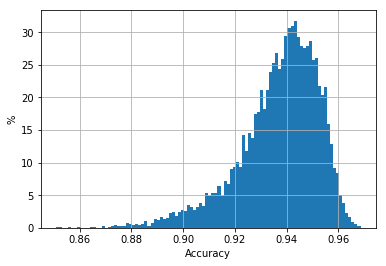

In [11]:
numBins = 100
plt.hist(data_maxSimDiff[load_structure],bins=numBins, normed=True);
plt.xlabel('Accuracy');
plt.ylabel('%');
plt.grid()


In [12]:
best_weights,_ = fun_find_max(data_weight[load_structure], data_maxSimDiff[load_structure],mode='returnFirst')
best_weights

array([[ 0.56246035],
       [ 0.37960882],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.04887654],
       [ 0.00186489],
       [ 0.        ],
       [ 0.0071894 ],
       [ 0.        ],
       [ 0.        ]])

In [13]:
ori_best_weights = np.array([[0.5,0.5,0,0,0,0,0,0,0,0,0]]).T

In [50]:
fun_SGD_score_v2(best_weights,np.vstack(tuple(positive_training_data.values())),np.vstack(tuple(negative_training_data.values())) )

(array([ 0.85]), 0.96494782727974349)

In [51]:
fun_SGD_score_v2(ori_best_weights,np.vstack(tuple(positive_training_data.values())),np.vstack(tuple(negative_training_data.values())) )

(array([ 0.9]), 0.97407535427420699)

In [52]:
temp1, temp2, temp3 = fun_ROC(np.dot(np.vstack(tuple(positive_training_data.values())), best_weights), np.dot(np.vstack(tuple(negative_training_data.values())) , best_weights) )

In [53]:
temp4, temp5, temp6 = fun_ROC(np.dot(np.vstack(tuple(positive_training_data.values())), ori_best_weights), np.dot(np.vstack(tuple(negative_training_data.values())), ori_best_weights) )

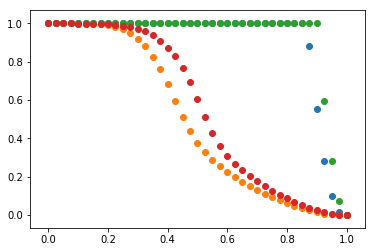

In [54]:
plt.scatter(temp1, temp2,label='Best_Positive')
plt.scatter(temp1, temp3,label='Best_Negative')
plt.scatter(temp1, temp5)
plt.scatter(temp1, temp6)

In [57]:
flatten_positive_training_data = np.vstack(tuple(positive_training_data.values()))
flatten_negative_training_data = np.vstack(tuple(negative_training_data.values()))

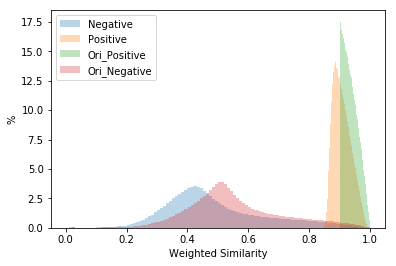

In [60]:
tempBinNum = 100
tempNormed = True
tempCumulated = False
positive_weighted_similarity = np.dot(flatten_positive_training_data, best_weights)
negative_weighted_similarity = np.dot(flatten_negative_training_data, best_weights)
ori_positive_weighted_similarity = np.dot(flatten_positive_training_data, ori_best_weights)
ori_negative_weighted_similarity = np.dot(flatten_negative_training_data, ori_best_weights)
plt.hist(negative_weighted_similarity,bins=tempBinNum,normed=tempNormed, alpha=0.3,cumulative=tempCumulated, label='Negative');
plt.xlabel('Weighted Similarity')
plt.ylabel('%')
plt.hist(positive_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Positive');
plt.hist(ori_positive_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Ori_Positive');
plt.hist(ori_negative_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Ori_Negative');
plt.legend()


In [84]:
data_weight[load_structure][0]

array([[ 0.53973386],
       [ 0.08033628],
       [ 0.        ],
       [ 0.        ],
       [ 0.05714221],
       [ 0.        ],
       [ 0.        ],
       [ 0.14976463],
       [ 0.06842964],
       [ 0.10459339]])

In [86]:
data_weight[load_structure][:,2,0]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   5.78235576e-05,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [63]:
training_sample_num_pos

{'data_set': 'NoCoors_RandomFalseMatched',
 'learning_rate': 0.05,
 'max_sample_num': 10000,
 'method': 'SGD_10_11',
 'numTrial': 10000,
 'roc_scaning_step': 0.05,
 'save_root_folder': '/shared/blob_matching_atlas/training_weight',
 'stack': 'MD589',
 'training_props': ['area',
  'eccentricity',
  'compactness',
  'orientation',
  'moments_hu'],
 'weight_length': 11}

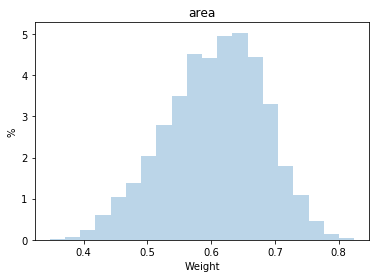

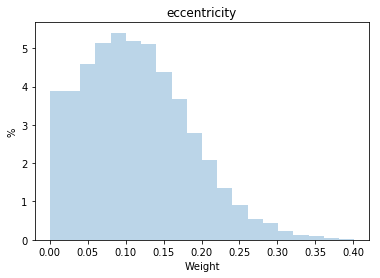

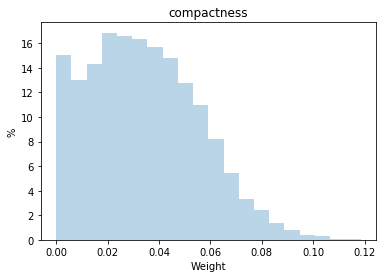

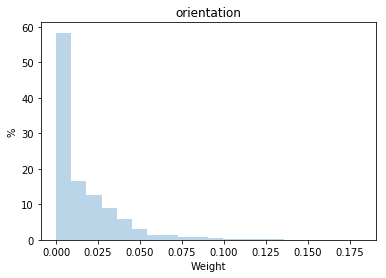

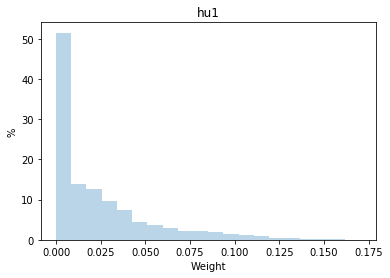

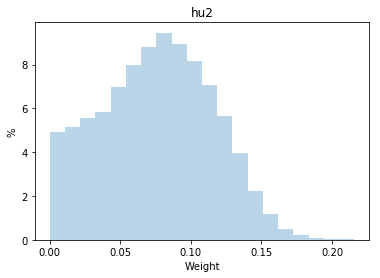

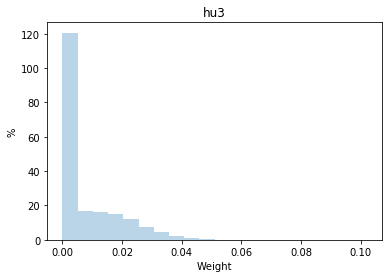

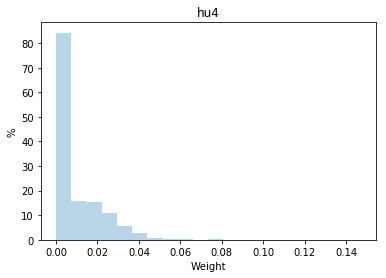

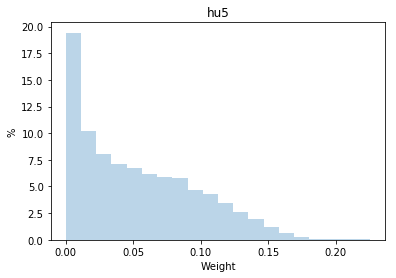

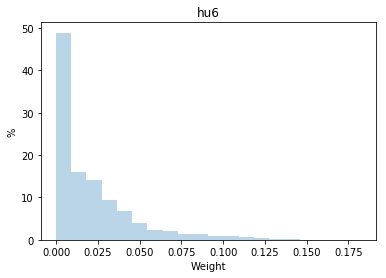

In [15]:
# tempTitle = learning_parameters['training_props'] + ['moments_hu']*6
tempTitle = ['area', 'eccentricity',  'compactness',  'orientation',  'hu1','hu2','hu3','hu4','hu5','hu6','hu7']
tempNormalized = True
for tempIdx in range(10):
    plt.figure()
    plt.hist(data_weight[load_structure][:, tempIdx, 0], bins=20, normed=tempNormalized, alpha=0.3);
    plt.title(tempTitle[tempIdx])
    plt.xlabel('Weight')
    plt.ylabel('%')


In [ ]:
load_structure = 'All'
data_tag = 'SGD_10_11'
data_weight = {}
data_maxSimDiff = {}

data_weight[load_structure] = load_data(fun_get_learning_data_path(what='weight', stack=stack, data_set=dataFolderName, structure_name=load_structure, method=data_tag))
data_maxSimDiff[load_structure] = load_data(fun_get_learning_data_path(what='maxSimDiff', stack=stack, data_set=dataFolderName, structure_name=load_structure, method=data_tag))